In [8]:
Copyright (c) [2018] [Prabhash Kumar Jha and Isheeta Jha] 



using PyPlot
using Distributions

function load_images()
    
    img0=PyPlot.imread("../data/i0.png")   ##loading the two images and ground truth 
    img1=PyPlot.imread("../data/i1.png")
    disparity=PyPlot.imread("../data/gt.png")
    
    img0 = 0.2989*img0[:,:,1] + 0.5870*img0[:,:,2] + 0.1140*img0[:,:,3]  ## converting the color images in grayscale
    img1 = 0.2989*img1[:,:,1] + 0.5870*img1[:,:,2] + 0.1140*img1[:,:,3]
       
    img0= convert(Array{Float64,2}, img0)    ## converting the pixel values to doubles
    img1= convert(Array{Float64,2}, img1)
    disparity =convert(Array{Float64,2}, disparity)

    return (img0::Array{Float64,2},img1::Array{Float64,2},disparity::Array{Float64,2});
end


function crop(img0::Array{Float64,2}, img1::Array{Float64,2}, gt::Array{Float64,2})
    
    I,J,V=findnz(gt)   ## I and J has row and column indices of non zero elements of disparity
    rowmin=minimum(I)
    rowmax=maximum(I)
    colmin=minimum(J)
    colmax=maximum(J)
   
    gt_crop=Array{Float64}(rowmax-rowmin+1,colmax-colmin+1)  ## initiliase the cropped ground truth image

    gt_crop=gt[rowmin:rowmax, colmin:colmax]  ## GT cropped

    img0_crop=img0[rowmin:rowmax, colmin:colmax]  ## I0 cropped
  
    img1_crop=img1[rowmin:rowmax, colmin:colmax]  ## I1 cropped  
 

return (img0_crop::Array{Float64,2}, img1_crop::Array{Float64,2}, gt_crop::Array{Float64,2})
end


function add_noise(img, percentage)
    
    
    rows=size(img,1)   ## calculate the dimension of image
    cols=size(img,2)
    
    img_noise=Array{Float64}(rows,cols)
    img_noise=deepcopy(img)

    # x% of elements of array to be noisy
    nIndexes=floor(rows*cols*percentage/100)  # find x% of rows to be filled with noise
    nIndexes=convert(Int64,nIndexes) # convert the value into integer

   total_elements=rows*cols
   noisy_index = sample(0:total_elements-1,nIndexes,replace=false)  ## get x% rows without replacement
   r = floor.(noisy_index./cols)+1
   r = convert.(Int64, r)
   c = noisy_index.%cols +1
    for i=1:nIndexes
            img_noise[r[i],c[i]]=rand()     ## gets uniformaly distributed value in the range 0 to 1
    end
     
    return img_noise::Array{Float64,2}
end



function apply_disparity(img::Array{Float64,2}, disparity::Array{Int64,2})

    nRow=size(img,1)
    nCol=size(img,2)
    
    img_d=Array{Float64}(nRow,nCol)
    
    for i=1:nRow
        for j=1:nCol
           img_d[i,j]=img[i, j-disparity[i,j]]  ## shift the image with disparity value   
        end
    end
    
return img_d::Array{Float64,2}
end


function compute_gaussian_lh(img0::Array{Float64,2}, img1_d::Array{Float64,2}, mu::Float64, sigma::Float64)
       
    
    x=img0-img1_d   ## difference between the first image and second image with disparity is x
    GL= (1/(sqrt(2*pi)*sigma))* exp.((-(x-mu).^2)/(2*sigma*sigma))  ## gaussian likelihood
    
    imshow(GL,"gray")
    
    lh=prod(GL)
      

    return lh::Float64
end


function compute_gaussian_nllh(img0::Array{Float64,2}, img1_d::Array{Float64,2}, mu::Float64, sigma::Float64)
    
     
    x=img0-img1_d;   ## difference between the first image and second image with disparity is x
  
    LGL = ((x-mu).^2)/(2*sigma*sigma)-log(1/(sqrt(2*pi)*sigma))  #1st term is variable 2nd term is const
    imshow(LGL,"gray")
    
    nrows=size(img0,1)
    ncol=size(img0,2)
    nllh=sum(LGL)
    const_term=-nrows*ncol*log(1/(sqrt(2*pi)*sigma))
    #display("constant term")
    #display(const_term)
    #display("variable term")
    #display(nllh-const_term)
   
   
     
    return nllh::Float64
end


function compute_laplacian_nllh(img0::Array{Float64,2}, img1_d::Array{Float64,2}, mu::Float64, s::Float64)
    
    x=img0-img1_d;
   
    LLL= abs.(x-mu)/s-log(1/(2*s))             #1st term is variable 2nd term is const
    imshow(LLL,"gray")
    nllh=sum(LLL)
    
    nrows=size(img0,1)
    ncol=size(img0,2)
   # const_term=-nrows*ncol*log(1/(2*s))
    
    
    #display("constant term")
    #display(const_term)
    #display("variable term")
    #display(nllh-const_term)
   
    return nllh::Float64
end
    





compute_laplacian_nllh (generic function with 1 method)

"Gaussian Likelihood value is"

0.0

"Gaussian  Negative Log Likelihood value is"

80715.34353861792

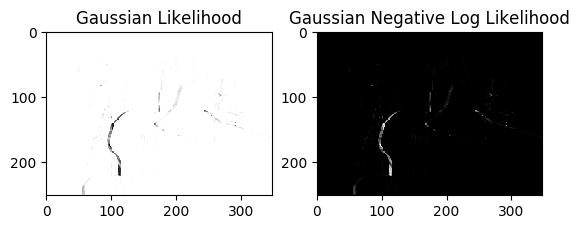

In [9]:



    img0,img1,disparity=load_images()   ## image loading done
     
    ## calculating the disparity of image 1

    disparity_int= disparity.*255     ## two steps to convert disparity value into integers

    disparity_int= round.(Int, disparity_int)

    img1_d=apply_disparity(img1, disparity_int)   ## applying disparity over image 1
    
  
    ####cropping

    img0_crop,img1_d_crop,gt_crop=crop(img0, img1_d, disparity)  ## cropping the center of image where disparity values are non zero

    mu=0.0
    sigma=1.0
    figure()
    subplot(121)
    l1h1=compute_gaussian_lh(img0_crop, img1_d_crop, mu, sigma)
    title("Gaussian Likelihood")
    
    
    display("Gaussian Likelihood value is")
    display(l1h1)

    #figure()
    subplot(122)
    nllh=compute_gaussian_nllh(img0_crop, img1_d_crop, mu, sigma)
    title("Gaussian Negative Log Likelihood")
    display("Gaussian  Negative Log Likelihood value is")
    display(nllh)



"Gaussian Likelihood value for 10% noise is"

0.0

"Gaussian Negative Log Likelihood value for 10% noise is"

82268.42208755785

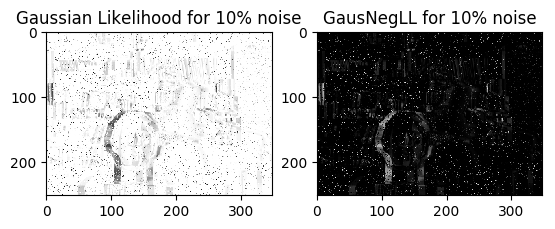

In [10]:

######################10% noise noise case##################################

    I1_noise=add_noise(img1, 10)   ## adding 10% noise to the image 1
   

    img1_d_noise=apply_disparity(I1_noise, disparity_int)
    ####cropping#################
    img0_crop,img1_d_crop_noise,gt_crop_noise=crop(img0, I1_noise, disparity)
    ############################
   
    mu=0.0
    sigma=1.0

    figure()
    subplot(121)
    l1h1n1=compute_gaussian_lh(img0_crop, img1_d_crop_noise, mu, sigma)
    title("Gaussian Likelihood for 10% noise")
    display("Gaussian Likelihood value for 10% noise is")
    display(l1h1n1)

    #figure()
    subplot(122)
    nllhn1=compute_gaussian_nllh(img0_crop, img1_d_crop_noise, mu, sigma)
    title("GausNegLL for 10% noise")
    display("Gaussian Negative Log Likelihood value for 10% noise is")
    display(nllhn1)

######################################################################


"Gaussian Likelihood value for 30% noise is"

0.0

"Gaussian Negative Log Likelihood value for 30% noise is"

83627.13932541168

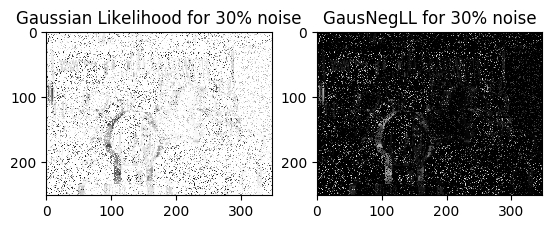

In [11]:

###################### 30% noise noise case##################################

    I1_noise2=add_noise(img1, 30)  ## adding 30% noise to image 1

    img1_d_noise=apply_disparity(I1_noise2, disparity_int) ## apply disparity on noisy image
####cropping#################
    img0_crop,img1_d_crop_noise2,gt_crop_noise2=crop(img0, I1_noise2, disparity)
############################

    mu=0.0
    sigma=1.0

    figure()
    subplot(121)
    l1h1n2=compute_gaussian_lh(img0_crop, img1_d_crop_noise2, mu, sigma)
    title("Gaussian Likelihood for 30% noise")
    display("Gaussian Likelihood value for 30% noise is")
    display(l1h1n2)

   # figure()
    subplot(122)
    nllhn2=compute_gaussian_nllh(img0_crop, img1_d_crop_noise2, mu, sigma)
    title("GausNegLL for 30% noise")
    display("Gaussian Negative Log Likelihood value for 30% noise is")
    display(nllhn2)

######################################################################


"Laplacian  Negative Log Likelihood value is"

62270.021887369934

"Laplacian Negative Log Likelihood value for 10% noise is"

70651.95697258366

"Laplacian Negative Log Likelihood value for 30% noise is"

75145.11751294922

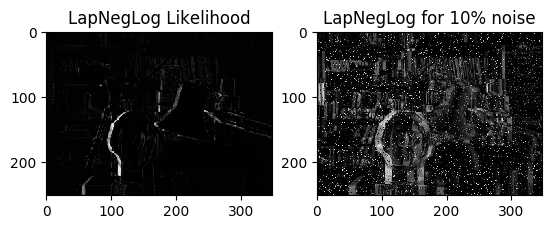

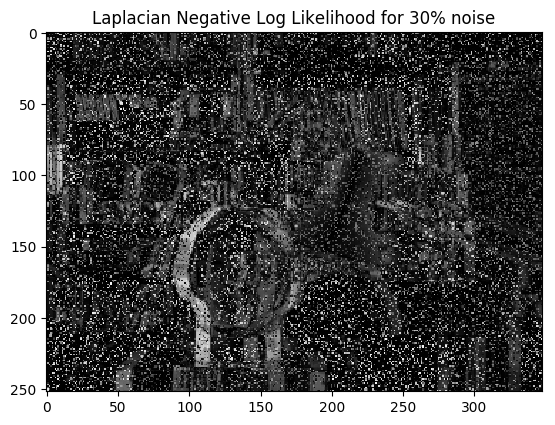

In [12]:

  
##############Negative log of Laplacian Likelihood####################
    
    s=1.0

    figure()
    subplot(121)
    nllh=compute_laplacian_nllh(img0_crop, img1_d_crop, mu, s)
    title("LapNegLog Likelihood")
    display("Laplacian  Negative Log Likelihood value is")
    display(nllh)

######################10% noise  case#######################

     
    subplot(122)
    nllhn1=compute_laplacian_nllh(img0_crop, img1_d_crop_noise, mu, s)
    title("LapNegLog for 10% noise")
    display("Laplacian Negative Log Likelihood value for 10% noise is")
    display(nllhn1)


##########################################################

###################### 30% noise noise case##############

    figure()
    #subplot(133)
    nllhn2=compute_laplacian_nllh(img0_crop, img1_d_crop_noise2, mu, s)
    title("Laplacian Negative Log Likelihood for 30% noise")
    display("Laplacian Negative Log Likelihood value for 30% noise is")
    display(nllhn2)


##########################################################
    




